In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import quad
import scipy.special as sc
from scipy.integrate import odeint
import scipy.integrate as integ
from scipy.optimize import curve_fit
import simulation_utility as su
import time
import json
import os
import math

In [4]:
wfs1 = su.read_waveforms_from_json(path='/home/pieramico/ABALONELYSO/results/SiPM',PE = 1, plot = True)

Number of waveforms 0, time to read 0.00


IndexError: list index out of range

<Figure size 576x324 with 0 Axes>

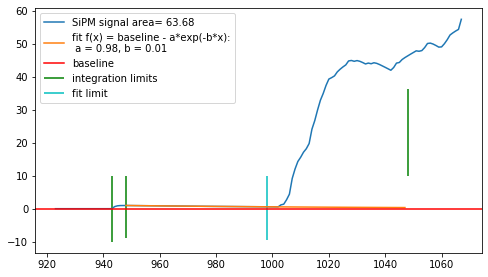

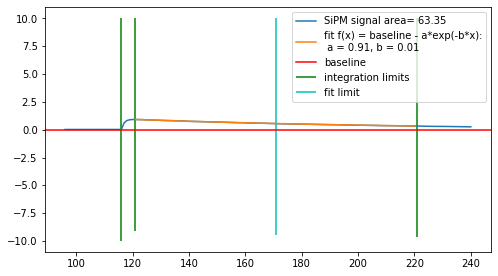

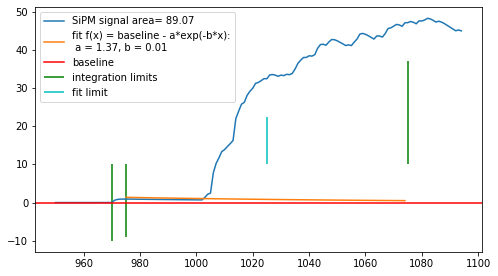

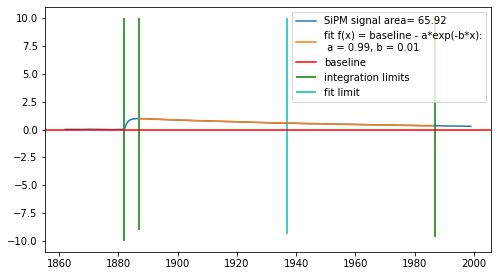

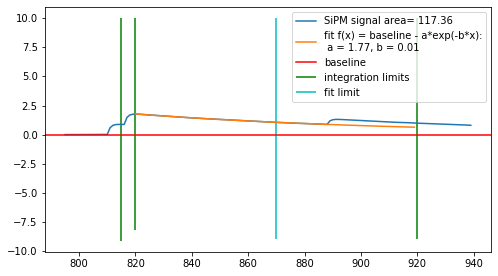

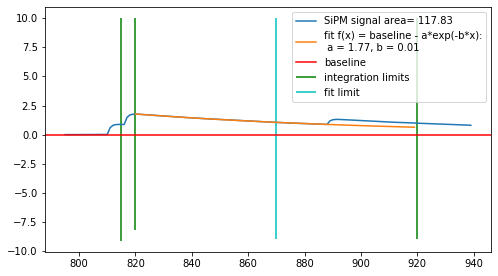

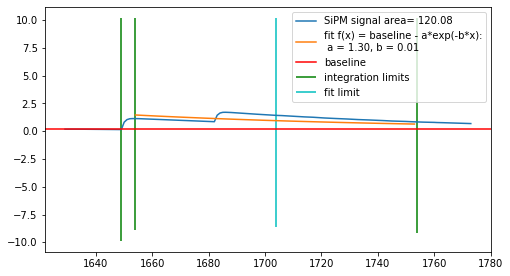

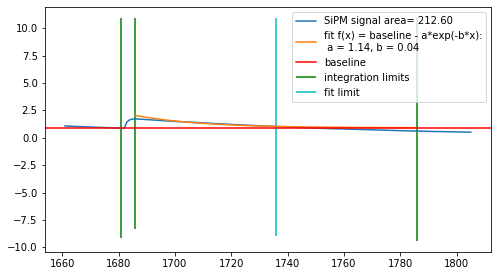

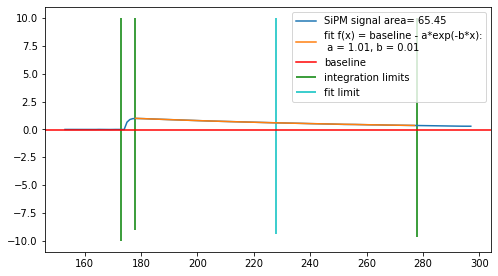

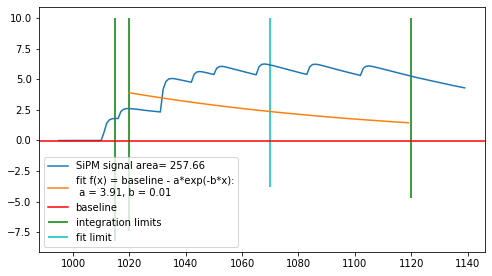

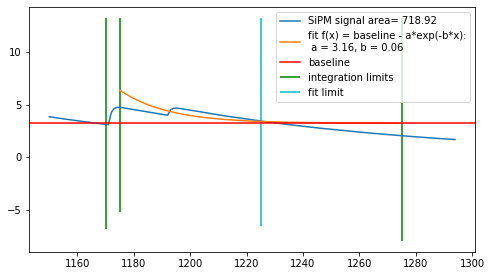

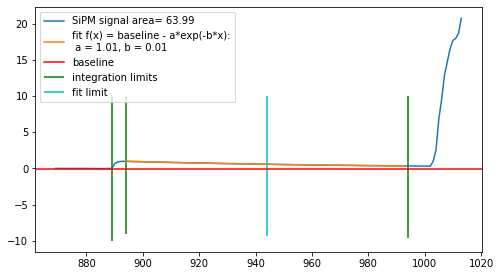

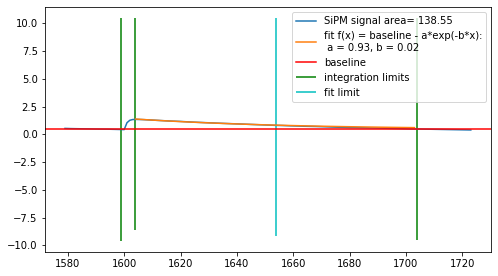

In [3]:
for i in range(5):
    listpeaks = su.search_peaks(wfs1[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs1[i],listpeaks,-5,0,50,100,5,8,10,plot=1,central=0)

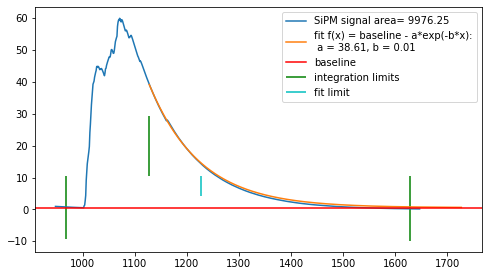

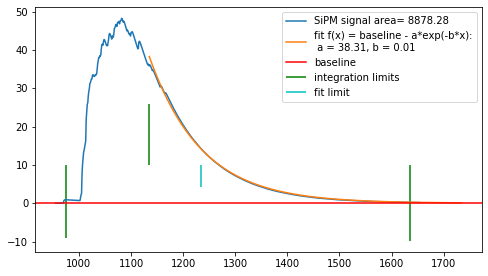

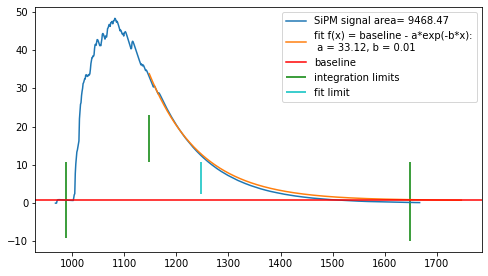

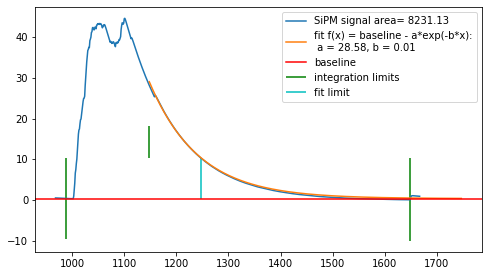

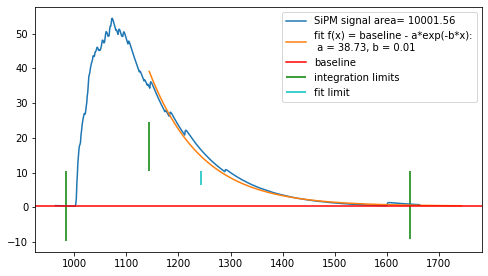

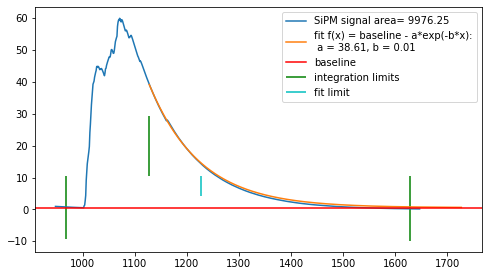

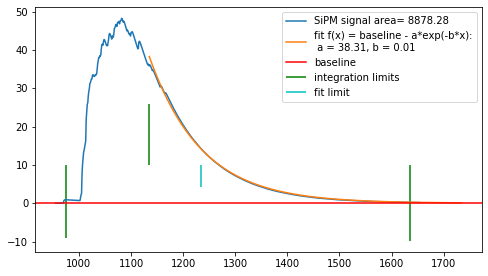

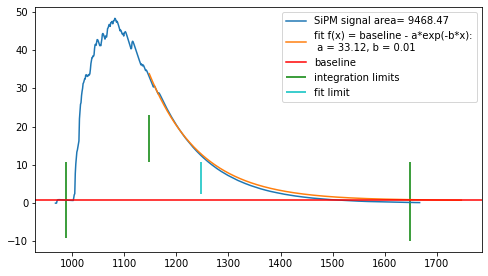

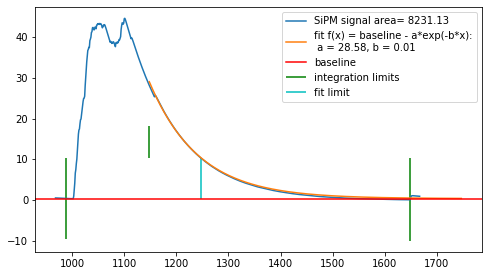

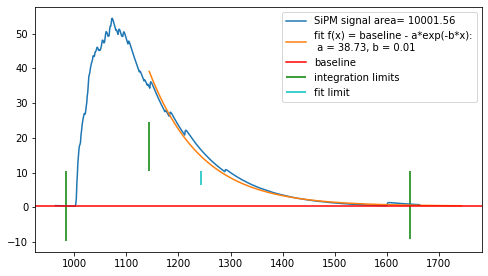

In [36]:
for i in range(10):
    listpeaks = su.search_peaks(wfs1[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs1[i],listpeaks,-60,100,200,600,15,30,10,plot=1)

In [5]:
def calculate_integrals(wfs,PE=1,angle=0):
    integrals = []
    t_start = time.time()
    for i in range(len(wfs)):
        listpeaks = su.search_peaks(wfs[i],5,0.5,plot=False)
        #ints = su.integral_simulation_peaks(wfs[i],listpeaks,-5,0,50,100,5,8,10,plot=0,central=0)
        #integrals.append(ints)
        ints = su.integral_simulation_peaks(wfs[i],listpeaks,-30,100,200,600,15,8,10,plot=0,central=1)
        integrals.append(ints)
        diff = time.time() - t_start
        if (i % 1000) == 0:
            print(f'event n. {i} time to process: {diff:.2f}')
    integrals = np.concatenate(integrals)
    np.save(f'integrals/integrals_PE{PE}_angle{angle}.npy',integrals)
    return integrals

In [6]:
integrals1 = calculate_integrals(wfs1,PE=1,angle=0)

event n. 0 time to process: 0.01
event n. 1000 time to process: 8.13
event n. 2000 time to process: 16.95
event n. 3000 time to process: 26.03
event n. 4000 time to process: 35.15
event n. 5000 time to process: 44.25
event n. 6000 time to process: 51.80
event n. 7000 time to process: 57.76
event n. 8000 time to process: 63.84
event n. 9000 time to process: 69.99
event n. 10000 time to process: 75.94
event n. 11000 time to process: 82.02
event n. 12000 time to process: 88.08
event n. 13000 time to process: 94.23
event n. 14000 time to process: 100.07
event n. 15000 time to process: 105.90
event n. 16000 time to process: 111.79
event n. 17000 time to process: 117.95
event n. 18000 time to process: 123.93
event n. 19000 time to process: 130.08
event n. 20000 time to process: 135.96
event n. 21000 time to process: 141.98
event n. 22000 time to process: 147.99
event n. 23000 time to process: 154.10
event n. 24000 time to process: 160.09
event n. 25000 time to process: 166.07
event n. 26000 

# Simulation with 2PE

Number of waveforms 10005, time to read 7.90


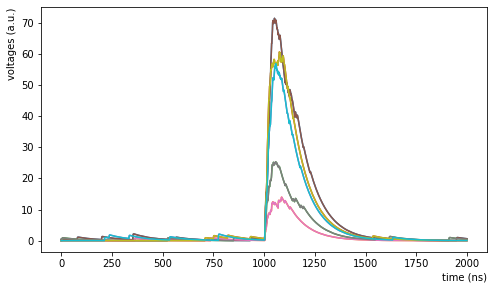

In [7]:
wfs2 = su.read_waveforms_from_json(PE = 2, plot = True)

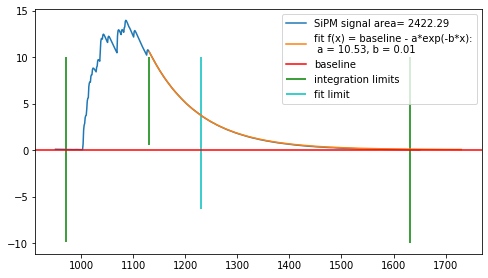

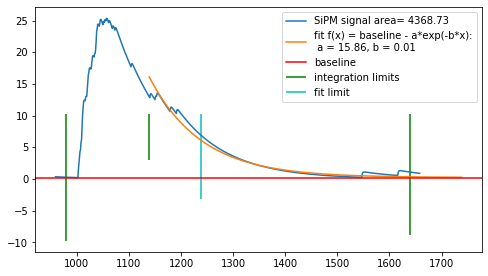

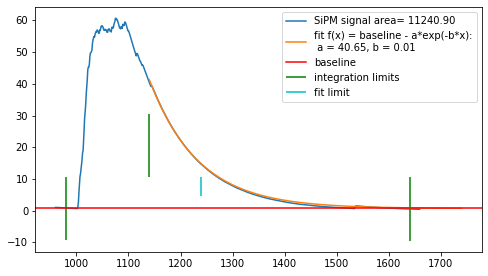

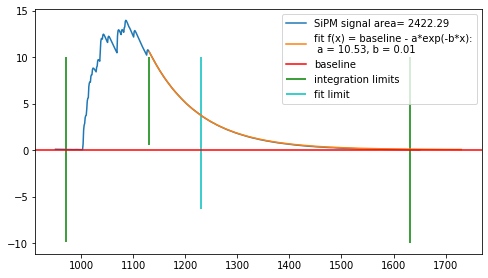

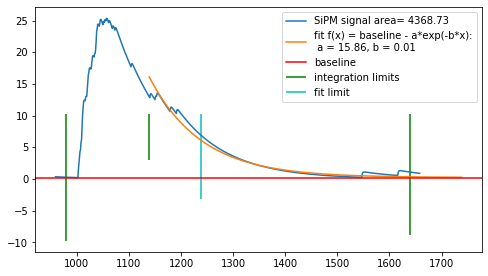

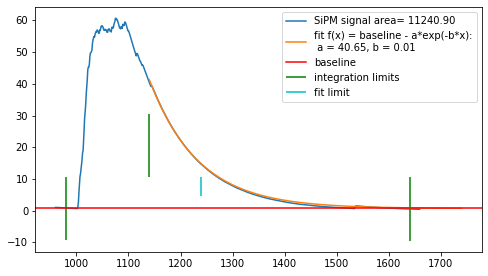

In [37]:
for i in range(10):
    listpeaks = su.search_peaks(wfs2[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs2[i],listpeaks,-60,100,200,600,15,8,10,plot=1)

In [9]:
integrals2 = calculate_integrals(wfs2,PE=2,angle=0)

event n. 0 time to process: 0.00
event n. 1000 time to process: 5.58
event n. 2000 time to process: 11.58
event n. 3000 time to process: 17.38
event n. 4000 time to process: 23.10
event n. 5000 time to process: 28.59
event n. 6000 time to process: 34.31
event n. 7000 time to process: 40.13
event n. 8000 time to process: 45.79
event n. 9000 time to process: 51.39
event n. 10000 time to process: 56.98


# Simulation with 3PE

Number of waveforms 10005, time to read 8.64


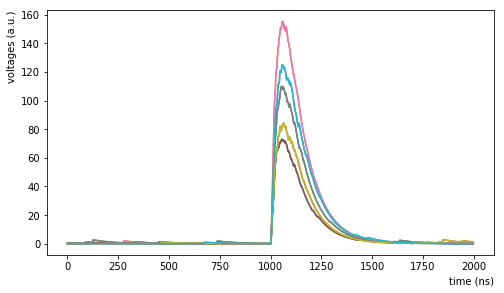

In [7]:
wfs3 = su.read_waveforms_from_json(PE = 3, plot = True)

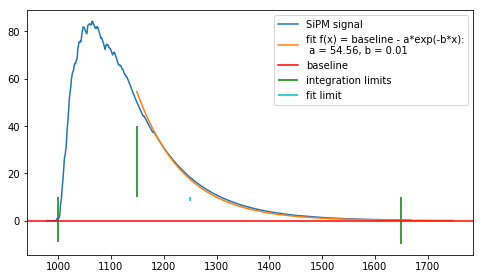

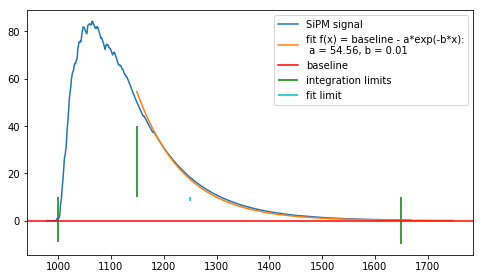

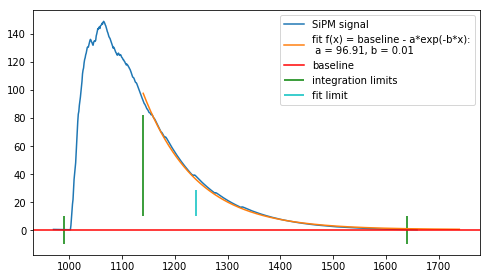

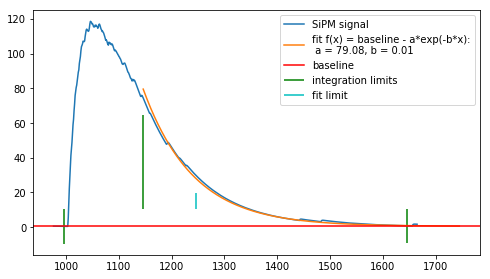

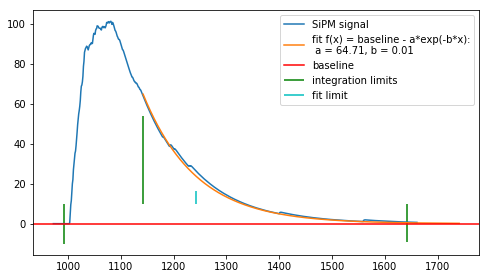

In [11]:
for i in range(20):
    listpeaks = su.search_peaks(wfs3[i],5,0.5,plot=False)
    ints = su.integral_simulation_peaks(wfs3[i],listpeaks,-50,100,200,600,15,8,10,plot=1)

In [12]:
integrals3 = calculate_integrals(wfs3, PE = 3, angle = 0)

event n. 0 time to process: 0.00
event n. 1000 time to process: 4.63
event n. 2000 time to process: 9.18
event n. 3000 time to process: 13.65
event n. 4000 time to process: 18.28
event n. 5000 time to process: 22.88
event n. 6000 time to process: 27.62
event n. 7000 time to process: 32.05
event n. 8000 time to process: 36.53
event n. 9000 time to process: 41.33
event n. 10000 time to process: 45.92


In [27]:
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2. * sigma**2))

def spe_fit(integrals1, integrals2, xrange=(1000,25000), bins=200, log=False,
            range1=(6000,11000), guess1 = (250,5000,1000),
            range2=(9000,12000), guess2 = (50,11000,1000)):
    print(f'n. events: 1PE={len(integrals1)}, 2PE={len(integrals2)}')
    h1, x1 = np.histogram(integrals1,bins=bins,range=xrange,density=1)
    h2, x2 = np.histogram(integrals2,bins=bins,range=xrange,density=1)
    #h3, x3 = np.histogram(integrals3,bins=bins,range=xrange)
    
    idx1, idx2 = np.where(x1>range1[0])[0][0], np.where(x1>range1[1])[0][0]
    popt, pcov = curve_fit(gaussian, x1[idx1:idx2], h1[idx1:idx2], p0=guess1)
    perr = np.sqrt(np.diag(pcov))
    print('SPE fit results',*popt)
    
    idxx1, idxx2 = np.where(x2>range2[0])[0][0], np.where(x2>range2[1])[0][0]
    popt2, pcov2 = curve_fit(gaussian, x2[idxx1:idxx2], h2[idxx1:idxx2], p0=guess2)
    perr2 = np.sqrt(np.diag(pcov2))
    print('DPE fit results',*popt2)
    
    plt.figure(figsize=(8,4.5))
    plt.plot(x1[1:],h1,label='Simulation with 1 PE')
    plt.plot(x2[1:],h2,label='Simulation with 2 PE')
    #plt.plot(x3[1:],h3,label='Simulation with 3 PE')
    #plt.plot(x1, gaussian(x1, *guess),label='Guess')
    plt.plot(x1[idx1:idx2], gaussian(x1[idx1:idx2], *popt),label=f'SPE at {popt[1]:.1f}')
    plt.plot(x2[idxx1:idxx2], gaussian(x2[idxx1:idxx2], *popt2),label=f'DPE at {popt2[1]:.1f}')
    #plt.axvspan(*fit_range, alpha=0.1, color='blue', label='fit region')
    if log: plt.yscale('log')
    plt.legend()

n. events: 1PE=27078, 2PE=6514
SPE fit results 0.00023804533595357227 8391.581635385428 1207.0598127253284
DPE fit results 7.02397098769451e-05 16272.503843285282 1991.8808557273437


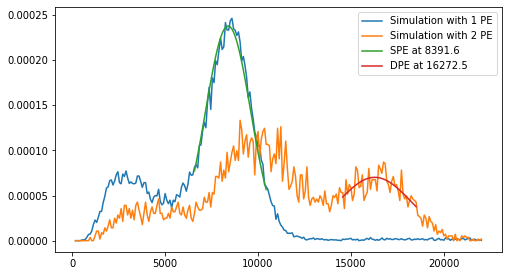

In [31]:
integrals1 = np.load(f'integrals/integrals_PE1_angle0.npy')
integrals2 = np.load(f'integrals/integrals_PE2_angle0.npy')
#integrals3 = np.load(f'integrals/integrals_PE3_angle0.npy')
spe_fit(integrals1, integrals2, xrange=(100,22000),bins=250,range1=(6500,10500),range2=(14500,18500))

In [2]:
def simple_integral_central_peak( wfs, dtl = 100, dtr = 100, plot=False):
    integrals = []
    for i in range(len(wfs)):
        wf = wfs[i]
        tt = np.array([i for i in range(len(wf))])
        amp = np.max(wf) #local amplitude of the signal
        tmax = tt[wf == amp][0]
        tl = tt[(tt <= tmax+dtr) & (tt >= tmax-dtl)]
        wfl = wf[(tt <= tmax+dtr) & (tt >= tmax-dtl)]
        integral = integ.simps(wfl, tl)
        integrals.append(integral)
        if plot:
            plt.figure(figsize=(8,4.5))
            tplot = tt[tmax-dtl-20:tmax+dtr+20]
            plt.plot(tplot,wf[tmax-dtl-20:tmax+dtr+20],label=f'SiPM signal: A = {integral:.1f}')
            plt.vlines((tmax-dtl), 10, 0, colors = 'g',
                       label = 'integration limits')
            plt.vlines((tmax+dtr), 10, 0, colors = 'g')
            plt.axhline(0, color = 'r')
            plt.legend()
        
    #np.save(f'integrals/integrals_PE{PE}_angle{angle}.npy',integrals)
    return integrals

In [3]:
realint1 = simple_integral_central_peak( wfs1, 70, 600)   
realint2 = simple_integral_central_peak( wfs2, 70, 600)
realint3 = simple_integral_central_peak( wfs3, 70, 600)

NameError: name 'wfs1' is not defined

n. events: 1PE=37265, 2PE=10005
SPE fit results 0.00021139930959922552 8514.2236622632 1184.0125686982071
DPE fit results 9.498303263915471e-05 16791.014344039155 1689.7620081640448


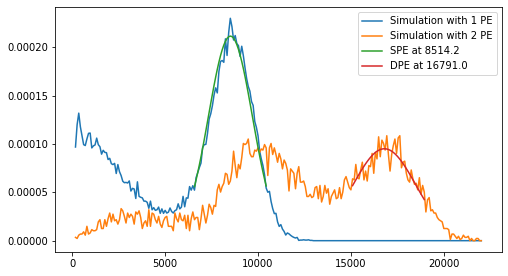

In [35]:
spe_fit(realint1, realint2, xrange=(100,22000),bins=250, range1=(6500,10500), range2=(15000,19000))